In [11]:
# Download data from GitHub
!pip install wget -qU
import wget
import os.path

def download_from_our_github_repo(file_path, force_new_download=False):
  if force_new_download or not os.path.isfile(file_path):
      url = f"https://github.com/ko-redtruck/facial-landmark-detection/raw/main/{file_path}"  
      wget.download(url, ".")

## Download helper functions


In [2]:
download_from_our_github_repo('project-submission/data_loading.py')
download_from_our_github_repo('project-submission/data_visualisation.py')
download_from_our_github_repo('project-submission/train.py')


## Load data & process data

Each image is randomly resized, repositioned and rotated. Changes in brightness, sharpness, hue and colors are also randomized. The empty space resulting from geometric transformations are filled with noise, a random solid color or the pixels from the edge.

30


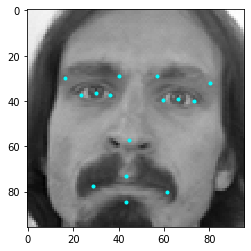

30


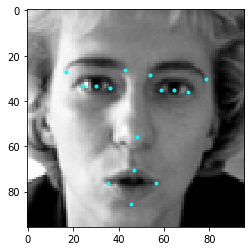

30


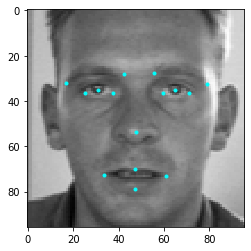

30


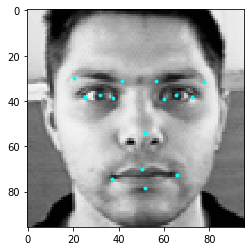

30


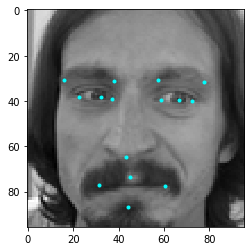

Downloaded dataset and extracted images & labels
Final image shape: torch.Size([3, 224, 224])
30


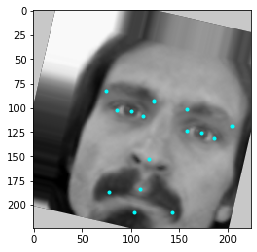

30


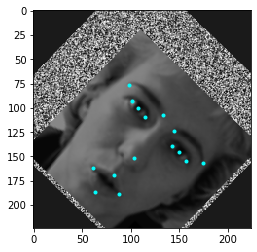

30


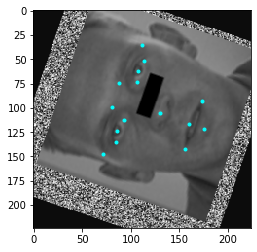

30


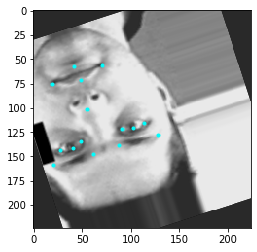

30


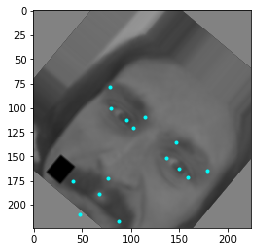

Preprocessed and augmented data


In [3]:
from data_loading import get_facial_landmark_detection_data, preprocess_data
from data_visualisation import plot_images

images, labels = get_facial_landmark_detection_data('./data')
plot_images(images, labels, num=5)
print('Downloaded dataset and extracted images & labels')

preprocessed_images, preprocessed_labels = preprocess_data(images, labels, target_size=(224, 224),
                  dataset_multiplier=2,
                  max_crop_length=30, display_samples=False)
plot_images(preprocessed_images, preprocessed_labels, num=5)
print('Preprocessed and augmented data')

## Load our best pretrained model

Please upload the files both model files from https://drive.google.com/drive/folders/13vn49AXvIuQvwhzh9xFZueLjGpKQNTn6 to your runtime first.

In [18]:
download_from_our_github_repo('project-submission/net_loading.py', force_new_download=True)

from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights
import torch
import torch.nn as nn

def add_final_layer(network, layer):
    network.fc = layer
    return network

def load_net(net: str, net_artifact: str, device):
    # Define parameter mappings
    final_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 30)
        )
  
    networks = {
        "ResNet18": add_final_layer(resnet18(weights=ResNet18_Weights.DEFAULT), final_layer),
        "ResNet34": add_final_layer(resnet34(weights=ResNet34_Weights.DEFAULT), final_layer)
    }

    network = networks[net].to(device)
    state_dict = torch.load(net_artifact, map_location=device)
    network.load_state_dict(state_dict)

    return networks[net].to(device)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NET_ARCHITECURE = 'ResNet18'

if NET_ARCHITECURE == 'ResNet34':
  net = load_net('ResNet34','ResNet34(v12).pickle', device)
elif NET_ARCHITECURE == 'ResNet18':
  net = load_net('ResNet18','/content/ResNet34(v12).pickle', device)

RuntimeError: ignored

## Load & predict demo video

We have provided a test video file but you can upload any mp4 videos to test the model.

In [ ]:
download_from_our_github_repo('matthis_vid_v1.mp4')
download_from_our_github_repo('project-submission/video_processing.py')
download_from_our_github_repo('project-submission/prediction.py')

from video_processing import extract_frames_from, opencv_to_pil_image, opencv_images_to_video, pil_to_opencv_image
from prediction import predict_and_draw_facial_landmarks

Test_video_file = 'matthis_vid_v1.mp4'

frames = [opencv_to_pil_image(opencv_image) for opencv_image in extract_frames_from(Test_video_file)]

predicted_landmarks = predict_and_draw_facial_landmarks(frames,net=net)
opencv_images_to_video([pil_to_opencv_image(pil_image) for pil_image in frames],'video_predicted.mp4')

